# Project roadmap and code

## Table of contents
1. [Questions](#1\.-Questions)
2. [Schedule](#2\.-Schedule)
3. [Documentation and first hands-on](#3\.-Documentation-and-first-hands-on)
4. [Data generation](#4\.-Data-generation)
5. [Data processing](#5\.-Data-processing)
6. [Machine learning](#6\.-Machine-learning)

## 1. Questions

Questions I wonder are grouped here:

- *In IGV usage*: **Question:** I'm not sure how to understand the vcf file in IGV, how do I know if it's an insertion or a deletion? Do the files I loaded correspond to one another? ✔️
- *In Data processing*: **Question:** Since we 'stream' data what's the best way to split train/test. Split certain positions? Split while iterating over batches? Train on chromosome 2, test on chromosome 1? ✔️
- *In Data processing*: **Question:** Some positions aren't found in the bedgraphs. Should put to 0 or -1 or another value? ✔️
- *In Data processing*: **Question:** Is window size 101 actually reasonable? ✔️
- *In Machine learning*: **Question:** How good are the results? ✔️

## 2. Schedule

### Week 1
- Meeting and get in touch with colleagues and Rick's work ✔️
- Download data and visualize with IGV ✔️
- Get in touch with formats (vcf, bam, ...) ✔️
- Read gnomAD paper ✔️

### Week 2
- Look at how they extract their features in the papers ✔️
- Extract data with Canevas from one genome of Genome in a Bottle ✔️
- Load data and pre-process it if needed ✔️
- Process data in python, vcf, signals data ✔️

### Week 3
- Check different approaches taken by papers to maybe take inspiration of window sizes or similar ✔️
- Filter VCF to event that pass filters ✔️
- Generate data by taking breakpoints of vcf and computing windows around them and windows with no events ✔️
- Split tain test ✔️
- Train model (deep net or random forest) ✔️

### Week 4
- Download bam from curated VCF paper (if linked) for HG03 and HG004 ✔️
- Dowload curated VCF from paper and load it correctly ✔️
- Generate data for HG003 and HG004 ✔️
- Train model on one sequence and test on another to compare performance to see if the model can detect deletions on an unseen sequence (better than random or not?) ✔️
- Look at signals' feature importance ✔️

## 3. Documentation and first hands-on

This section will contain the steps done towards documentation, data exploration, IGV usage

### IGV usage

First, I downloaded [IGV 2.8.3](http://software.broadinstitute.org/software/igv/download) for Linux

Then I downloaded this data [here](ftp://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/NA12878/NA12878_PacBio_MtSinai/) from [Genome in a Bottle](https://www.nist.gov/programs-projects/genome-bottle):
- `NA12878.sorted.vcf.gz`
- `NA12878.sorted.vcf.gz.tbi`
- `README.txt`
- `merged_ec_output_primary.bam`
- `merged_ec_output_primary.bam.bai`

I tried to load `NA12878.sorted.vcf.gz` and `merged_ec_output_primary.bam` in IGV but there was a parsing error in the vcf file:
- I realized line 4 `#contig=<ID=chr1,...` was missing a `#` at the begginning
- I had to change the spaces in the header line to `\t`

I then was able to load the two files in IGV and have a visualization:

**Question:** I'm not sure how to understand the vcf file in IGV, how do I know if it's an insertion or a deletion? Do the files I loaded correspond to one another?

![IGV image](images/igv-NA12878-1.png)

## 4. Data generation

This section will contain the steps done towards data creation with [Canevas](https://github.com/rick-heig/canevas), different filters used

The `bam` file `merged_ec_output_primary.bam` I had was in long reads, thus it wasn't usable in Canevas and wasn't the format we want.

I asked the Genome Center for a short reads `bam` file on one chromosome and for now Rick gave me data generated with Canevas on `Guipponi.NA12878-A.mdup.sorted.bam.bqsr.bam` for chromosome 21 to start with

I then downloaded the `RMNISTHS_30xdownsample.bam` at ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/NA12878/NIST_NA12878_HG001_HiSeq_300x/ and extracted the features for chromosome 2, using Canevas and this very command:

`sbt run signal extract -b /home/lulu/Documents/Work/genome-center/data/RMNISTHS_30xdownsample.bam -o out -r 2`

Later I downloaded two bams for HG003 and HG004 and generated signals for chromosome 1 and their curated VCF from https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007933. I chose HG003 and HG004 because we now have a nicely curated VCF for them, they have similar bams as they are in the same trio, finally I chose the parents because they a priori don't have intimate blood relation. Indeed, such a relation could induce a strong bias on wether or not a model trained on someone else can give reasonable predictions for another person:
- HG003: ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/HG003_NA24149_father/NIST_HiSeq_HG003_Homogeneity-12389378/NHGRI_Illumina300X_AJtrio_novoalign_bams/HG003.hs37d5.60x.1.bam
- HG004: ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/HG004_NA24143_mother/NIST_HiSeq_HG004_Homogeneity-14572558/NHGRI_Illumina300X_AJtrio_novoalign_bams/HG004.hs37d5.60x.1.bam
- VCF: ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_12122017/svanalyzer_union_171212_v0.5.0_annotated.vcf.gz

## 5. Data processing

This section will contain the steps done towards data processing in order to use it in the machine learning pipeline

There is a *lot* of data, we can't load all signals for the whole chromosome at the same time.

When training, we have to get part of the data, train on it and get next chunk. Otherwise we won't have enough memory

To do that, I decided to go for an object-oriented approach, since I want the 'readers' to have states. I ask for the next batch and it returns it, keeping the next values already loaded.

That way later I should be able to load a batch of each signal, split the batch in mini_batches, train the model on them and then load the next batches.

I added MultiSignal to combine signals easily and get multiple batches.

Then I added a `SignalExtractor` for VCF, given a vcf file, when requested a batch it would say which positions were deleted. First I had a `np.vectorize` function to do that, similar to a map; that checked each position in the vcf file. But it was slow, so I changed to a broadcasting way where I utilize numpy's way of doing it, which greatly sped up running time.

**Version 2.0**:
After talking, we realized it was better to check positions with deletions, select positions with no deletions and get data for these points in order to generate data. Instead of reading all batches one by one to generate data. So we need to, given positions, retrieve signal's data. So a signal will take some positions and retrieve all the windows for these positions.


**Version 2.1**:
Version 2.0 was slow, using the `line_profiler` I analyzed the code to see the slow steps and reworked the code to have a fast bedgraph reader. (Some `line_profiler` output are presented in the next cells):
- Since by reading chunks we'll go through most of the bedgraph, it's better to give all positions at once, to go through the file only once
- Using skiprows is in fact very slow, it's way faster to use `TextFileReader` that has a `get_chunk` function. It's faster because it keeps the last position it was at, whereas skiprows goes through the file.
- Numpy is faster at retrieving specific values but pandas is convenient. So I use pandas and then use `.values` for crucial steps
- Binary search is faster than broadcasting to find the value for a pos
- Don't search for positions that aren't in chunk
- Parallelize signals reading

The `applymap` to fill in values used to take 99% of time, after all this reworking, reading is the slowest part of the algorithm. But the `TextFileReader` is by far the fastest way I've seen.

Some values aren't in the bedgraph, so I assume they are 0. Maybe should assume they are -1? I now assume they are -1

Window size of 100 seems reasonable according to [A Deep Learning Approach for Detecting Copy Number Variation in Next-Generation Sequencing Data](https://lulix.net/~lcerutti/notes2/notes/lcerutti/Notebook/yfxOvpdrvuQu/files/2019-A_Deep_Learning_Approach_for_Detecting_Copy_Number_Variation_in_Next-Generation_Sequencing_Data.pdf)

Clean code and modify such that it is easy to load other signals and vcf to generate train/test data. In particular load data for HG003 and HG004 with curated vcf. Missing values are now put to `-1` because it makes more sense and it makes a distinction with value `0`

Change VCF manually (VCF used is on git in case the deleted lines is not clear, it's simply for easier processing, no changing the data):
- First line is the `#contig..` line for chrom 1 length
- Second line is the header for columns
- Delete all other metadata lines
- Then delete all line that are not for chromosome 1 (with vim: `:3,$v/^1\s/d`)

### Version 1 (deprecated)

In [1]:
%load_ext line_profiler

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pybedtools import BedTool

In [2]:
metadata_size = 3 # Number of metadata lines in bedgraph

chunk_size = 10000 # Number of lines read on bedgraph per iter
batch_size = 1000 # Number of values returned by SignalExtractor when asked for a batch

In [3]:
class SignalExtractor():
    def get_next_batch(self):
        raise NotImplementedError
        
    def has_next(self):
        raise NotImplementedError
        
    def reset(self):
        raise NotImplementedError

In [4]:
class SingleSignalExtractor(SignalExtractor):
    def __init__(self, bedgraph, data_dir='data/', metadata_size=metadata_size):
        self.bedgraph = BedTool(f'{data_dir}{bedgraph}')
        self.metadata_size = metadata_size
        self.skiprows = metadata_size # Remove metadata
        self.chunks_available = True
        self.batch_available = True
        self.remaining_values = np.array([])
        
        
    def get_next_batch(self):
        """
        Get next batch, which will have the `batch_size` next values. Can be smaller if there aren't enough values left
        """
        assert(self.has_next())
        
        if self.remaining_values.shape[0] >= batch_size:
            # There are enough values already read
            temp = self.remaining_values[:batch_size]
            self.remaining_values = self.remaining_values[batch_size:]
            return temp
        
        # Read next values
        df = self.bedgraph.to_dataframe(skiprows=self.skiprows, nrows=chunk_size)
        assert(df.isnull().sum().sum() == 0) # Check no missing values
        self.skiprows += len(df)
        
        # If there aren't as many rows as asked for, we are at the end of the file
        if len(df) < chunk_size:
            self.chunks_available = False
        
        # Repeat values the stated amount of time, since we want a continuous array of data
        df['repeat'] = df['end'] - df['start']
        df = df.drop(columns=['chrom', 'start', 'end'])
        df = df.reindex(df.index.repeat(df['repeat'])).reset_index(drop=True)
        df = df.drop(columns=['repeat'])
        
        # Put values in numpy and concatenate with previously loaded data
        values = df['name'].values
        values = np.concatenate([self.remaining_values, values])
        
        # Save remaining values and return batch
        self.remaining_values = values[batch_size:]
        
        self.batch_available = len(self.remaining_values) >= batch_size
        
        return values[:batch_size]
        
        
    def has_next(self):
        return self.chunks_available or self.batch_available
        
        
    def reset(self):
        self.skiprows = self.metadata_size
        self.chunks_available = True
        self.remaining_values = np.array([])

In [5]:
class MultiSignalExtractors(SignalExtractor):
    """
    Helper class to easily combine multiple signal extractors
    """
    def __init__(self, bedgraphs):
        self.signals = []
        
        for bedgraph in bedgraphs:
            if isinstance(bedgraph, SignalExtractor):
                self.signals.append(bedgraph)
            elif isinstance(bedgraph, str):
                self.signals.append(SingleSignalExtractor(bedgraph))
            else:
                raise ValueError
        
        
    def get_next_batch(self):
        """
        Get next batch for each signal and return them
        """
        batches = [signal.get_next_batch() for signal in self.signals]
        return np.stack(batches)
        
        
    def has_next(self):
        for signal in self.signals:
            if not signal.has_next():
                return False
        
        return True
        
        
    def reset(self):
        for signal in self.signals:
            signal.reset()

In [6]:
class VCFSignalExtractor(SignalExtractor):
    def __init__(self, vcf, data_dir='data/'):
        self.data = pd.read_table(f'{data_dir}{vcf}',
                                  skiprows=1,
                                  names=['chrom', 'pos', 'id', 'ref', 'alt', 'qual', 'filter', 'info', 'format', 'NA12878'],
                                  na_values='.')
    
        self.data = self.data[self.data['alt'] == '<DEL>'] # Only keep deletions
        self.data = self.data[self.data['filter'] == 'PASS'] # Only take variants that pass at least 3 filters
        self.data['end'] = self.data['info'].str.extract(r'^.*END=(\d+);.*$').astype(int)
        self.data = self.data.drop(columns=['id', 'ref', 'alt', 'qual', 'filter', 'info', 'format', 'NA12878'])
        self.data = self.data.rename(columns={'pos': 'start'})
        self.data = self.data.reset_index(drop=True)
                
        self.current_index = 0
        self.last_returned_pos = 0
        
    
    def _classify_batch(self, batch, requested_pos):
        """
        With broadcasting, check if positions are in-between a start-end pair or not and classify them
        All positions are >= 0, so while processing values >= 0 are not classified yet
            During computation:
            - `-2` means no deletion
            - `-1` means deletion
        """
        index = self.current_index
        while np.sum(batch >= 0) > 0:
            if index >= len(self.data):
                # No more data in vcf, so assume there are no deletions afterwards 
                batch[batch >= 0] = -2
            else:
                _, start, end = self.data.loc[index]
                
                # Before start, so if it wasn't classified yet, it's not deleted
                batch[(batch >= 0) & (batch < start)] = -2
                
                # Before end, so if it wasn't classified yet, it's between start and end -> deleted
                batch[(batch >= 0) & (batch < end)] = -1
                
                if end < requested_pos:
                    # Line is no longer needed, as we are further than it
                    self.current_index += 1
                
                index += 1
        
    
    def get_next_batch(self):
        requested_pos = self.last_returned_pos + batch_size
        
        if self.current_index >= len(self.data):
            # No more data in vcf, so assume there are no deletions afterwards
            self.last_returned_pos = requested_pos
            return np.zeros(batch_size)
        
        batch = np.arange(self.last_returned_pos, requested_pos)
        
        self._classify_batch(batch, requested_pos)
        
        # Convert temporary values used
        batch[batch == -2] = 0
        batch[batch == -1] = 1
        
        self.last_returned_pos = requested_pos
        return batch
        
        
    def has_next(self):
        # Always has_next since we assume that if there is no data left in vcf, there are no deletions
        return True
        
        
    def reset(self):
        self.current_index = 0
        self.last_returned_pos = 0

In [7]:
signals = [
    VCFSignalExtractor('NA12878.sorted.chr2.vcf'),
    '2_CigarIndels.bedgraph.gz',
    '2_Clipped.bedgraph.gz',
    '2_Coverage.bedgraph.gz',
    '2_DiscordantTandemOrientation.bedgraph.gz',
    '2_ForwardInsertSizeTooBig.bedgraph.gz',
    '2_InsertSizeTooBig.bedgraph.gz',
    '2_InsertSizeTooSmall.bedgraph.gz',
    '2_InterChr.bedgraph.gz',
    '2_MappingErrors.bedgraph.gz',
    '2_MAPQ0.bedgraph.gz',
    '2_MateUnmapped.bedgraph.gz'
]

signal_extractor = MultiSignalExtractors(signals)

In [8]:
%%time

batch = np.zeros((len(signals), batch_size))

while np.sum(batch[0, :]) == 0: # Iterate until we have a deletion
    batch = signal_extractor.get_next_batch()

CPU times: user 2.11 s, sys: 460 ms, total: 2.57 s
Wall time: 2.59 s


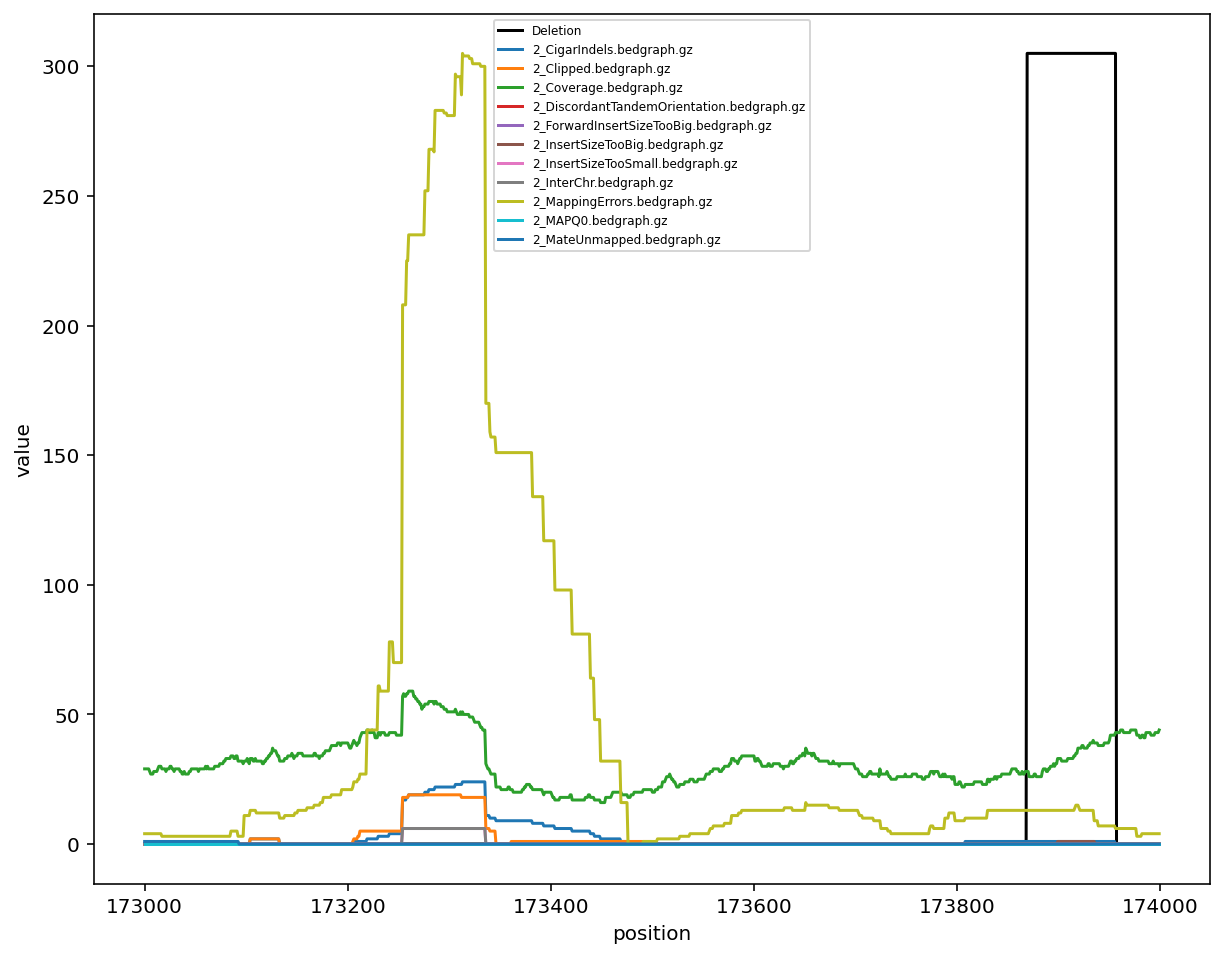

In [9]:
plt.figure(figsize=(10, 8), dpi=144)

x = np.arange(-batch_size, 0) + signals[0].last_returned_pos

plt.plot(x, batch[0]*np.max(batch), label='Deletion', color='black')


for i, signal in enumerate(batch[1:]):
    name = signals[i+1]
    plt.plot(x, signal, label=name)
    
plt.xlabel('position')
plt.ylabel('value')
plt.legend(fontsize=6)
plt.show()

### Version 2.0 (deprecated)

In [111]:
class SingleSignalExtractor(SignalExtractor):
    def __init__(self, bedgraph, data_dir='data/', chunk_size=100, metadata_size=metadata_size):
        self.bedgraph = BedTool(f'{data_dir}{bedgraph}')
        self.metadata_size = metadata_size
        self.chunk_size = chunk_size
        self.data = 
        
        
    def _pos_in_df(self, df, pos):
        return ((df['start'] <= pos) &
                (df['end'] >= pos))
        
        
    def get_window(self, pos):
        """
        Get next batch, which will have the `batch_size` next values. Can be smaller if there aren't enough values left
        """
        start, end = get_start_end_window(pos)
        
        skiprows = self.metadata_size
        nrows = self.chunk_size
        
        # Search start
        while True:
            print(skiprows, nrows)
            df = self.bedgraph.to_dataframe(skiprows=skiprows, nrows=nrows)
            if len(df) == 0:
                skiprows -= int(step/2)
            else:
                in_range = self._pos_in_df(df, start)
                if in_range.sum() > 0:
                    break

                chunk_start = df['start'].values[0]
                line_average_size = (df['end'] - df['start']).mean()

                too_far = chunk_start > start

                step = int(abs(start - chunk_start) / line_average_size)
                step = max(nrows, step)

                if too_far:
                    step = -step

                skiprows += step
            
        skiprows += np.argmax(in_range.values) # Go to start
        
        # Search end
        while not (in_range := self._pos_in_df(self.bedgraph.to_dataframe(skiprows=skiprows,\
                                                                          nrows=nrows,\
                                                                          usecols=['start', 'end']), end)).sum() > 0:
            nrows += nrows
            
        
        nrows = np.argmax(in_range.values)+1 # Go until end
        
        df = self.bedgraph.to_dataframe(skiprows=skiprows, nrows=nrows, usecols=['start', 'end', 'name'])
        
        assert(df.isnull().sum().sum() == 0) # Check no missing values
        
        window = np.arange(start, end+1)
        
        for i, row in df.iterrows():
            row_start = row['start']
            row_end = row['end']
            row_value = row['name']
            
            window[(window >= row_start) & (window <= row_end)] = -row_value
        
        window = -window
        
        return window

In [112]:
%lprun -f SingleSignalExtractor.get_window SingleSignalExtractor('2_MappingErrors.bedgraph.gz').get_window(20000000)

3 100
1741283 100
1855667 100
1939816 100
1955050 100
1952886 100
1952708 100


Timer unit: 1e-06 s

Total time: 2.32161 s
File: <ipython-input-111-b571b325cab2>
Function: get_window at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                               def get_window(self, pos):
    14                                                   """
    15                                                   Get next batch, which will have the `batch_size` next values. Can be smaller if there aren't enough values left
    16                                                   """
    17         1          5.0      5.0      0.0          start, end = get_start_end_window(pos)
    18                                                   
    19         1          1.0      1.0      0.0          skiprows = self.metadata_size
    20         1          1.0      1.0      0.0          nrows = self.chunk_size
    21                                                   
    22                                                   # Search start

### Version 2.1

In [1]:
%load_ext line_profiler
%load_ext autoreload

%autoreload 2

import time
from collections import defaultdict
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pybedtools import BedTool
from sklearn.model_selection import train_test_split

In [2]:
n_jobs = 8 # Number of cores
random_state = 42 # Seed
metadata_size = 3 # Number of metadata lines in bedgraph
window_size = 101
assert(window_size >= 3 and window_size % 2 == 1) # Check odd number

In [3]:
def get_start_end_window(pos):
    start = pos - (window_size-1)/2
    end = pos + (window_size-1)/2
    return start, end

In [4]:
class SignalExtractor():
    def get_windows(self, positions):
        raise NotImplementedError

In [5]:
class SingleSignalExtractor(SignalExtractor):
    def __init__(self, bedgraph, data_dir='data/', metadata_size=metadata_size, chunk_size=1000000):
        self.bedgraph = BedTool(f'{data_dir}{bedgraph}')
        self.metadata_size = metadata_size
        self.name = bedgraph.split('.')[0].split('_')[-1]
        
        self.chunk_size = chunk_size
        self.last_chunk_size = chunk_size
        
        self.dict = defaultdict(lambda: None)
        
    
    def _print_progress(self, progress):
        print(f"Signal {self.name} {progress:.1f}% complete")
        
        
    def _pos_in_df(self, values, pos):
        if pd.isna(pos):
            return pd.NA
        
        left = 0
        right = values.shape[0] - 1        
        
        while left <= right:
            mid = int((right - left) / 2) + left            
            
            start = values[mid, 0]
            end = values[mid, 1]
            
            if start <= pos and pos <= end:
                return mid
            elif end <= pos:
                if left == mid:
                    mid += 1
                left = mid
            elif start >= pos:
                if right == mid:
                    mid -= 1
                right = mid
            else:
                raise ValueError
        
        return pd.NA
    
    
    def _fill_value(self, pos, chunk_values):        
        if pd.isna(pos) or pos <= 0:
            return pos
        
        start_chunk = chunk_values[0, 0]
        end_chunk = chunk_values[-1, 1]
        
        if pos < start_chunk or pos > end_chunk:
            # pos not in chunk
            return pos
        
        value = self.dict[pos]
        
        if value != None:
            return value
        
        index = self._pos_in_df(chunk_values, pos)
        
        if pd.isna(index):
            return pd.NA # Value not in bedgraph
        
        row = chunk_values[index]
        
        start = row[0]
        end = row[1]
        value = -row[2]

        for i in range(start, end+1):
            self.dict[i] = value

        return value
        
        
    def get_windows(self, positions, prefix_str=""):
        """
        Get next batch, which will have the `batch_size` next values. Can be smaller if there aren't enough values left
        """
        file_reader = self.bedgraph.to_dataframe(iterator=True, skiprows=3, chunksize=self.chunk_size, usecols=['start', 'end', 'name'])
        
        windows = np.empty((len(positions), window_size))
        starts, ends = get_start_end_window(positions)
        
        for i in range(len(positions)):
            windows[i] = np.arange(starts[i], ends[i]+1)
            
        
        number_values = windows.size
        windows = pd.DataFrame(windows)
        
        progress = 0
        self._print_progress(progress)
        
        number_values_left = number_values
            
        
        while number_values_left > 0:
            chunk = file_reader.get_chunk()
            chunk_values = chunk.values
            last_chunk = chunk_values.shape[0] < self.chunk_size
            
            windows = windows.applymap(lambda pos: self._fill_value(pos, chunk_values))
            
            if last_chunk:
                windows[windows > 0] = pd.NA # Values not in bedgraph
            
            number_values_left = (windows > 0).sum().sum()
            
            new_progress = (1 - number_values_left / number_values) * 100.0
            if new_progress > progress:
                progress = new_progress
                self._print_progress(progress)
            
                    
        return -windows

In [6]:
# Test line profiler
%lprun -f SingleSignalExtractor.get_windows SingleSignalExtractor('HG001_2_Coverage.bedgraph.gz').get_windows(np.array([100000, 1230123, 12312314, 1435456, 43765, 6575756, 45546, 4735734]))

Signal Coverage 0.0% complete
Signal Coverage 62.5% complete
Signal Coverage 75.0% complete
Signal Coverage 87.5% complete
Signal Coverage 100.0% complete


Timer unit: 1e-06 s

Total time: 1.33715 s
File: <ipython-input-5-d55b1362f419>
Function: get_windows at line 79

Line #      Hits         Time  Per Hit   % Time  Line Contents
    79                                               def get_windows(self, positions, prefix_str=""):
    80                                                   """
    81                                                   Get next batch, which will have the `batch_size` next values. Can be smaller if there aren't enough values left
    82                                                   """
    83         1       5703.0   5703.0      0.4          file_reader = self.bedgraph.to_dataframe(iterator=True, skiprows=3, chunksize=self.chunk_size, usecols=['start', 'end', 'name'])
    84                                                   
    85         1          9.0      9.0      0.0          windows = np.empty((len(positions), window_size))
    86         1         29.0     29.0      0.0          starts, ends = get_sta

In [7]:
# Test line profiler
%lprun -f SingleSignalExtractor._fill_value SingleSignalExtractor('HG001_2_CigarIndels.bedgraph.gz').get_windows(np.array([100000, 1230123, 12312314, 1435456, 43765, 6575756, 45546, 4735734]))

Signal CigarIndels 0.0% complete
Signal CigarIndels 100.0% complete


Timer unit: 1e-06 s

Total time: 0.015151 s
File: <ipython-input-5-d55b1362f419>
Function: _fill_value at line 46

Line #      Hits         Time  Per Hit   % Time  Line Contents
    46                                               def _fill_value(self, pos, chunk_values):        
    47       816       1235.0      1.5      8.2          if pd.isna(pos) or pos <= 0:
    48                                                       return pos
    49                                                   
    50       816        467.0      0.6      3.1          start_chunk = chunk_values[0, 0]
    51       816        337.0      0.4      2.2          end_chunk = chunk_values[-1, 1]
    52                                                   
    53       816       2919.0      3.6     19.3          if pos < start_chunk or pos > end_chunk:
    54                                                       # pos not in chunk
    55                                                       return pos
    56          

In [8]:
# Test line profiler
%lprun -f SingleSignalExtractor._pos_in_df SingleSignalExtractor('HG001_2_MappingErrors.bedgraph.gz').get_windows(np.array([100000, 1230123, 12312314, 1435456, 43765, 6575756, 45546, 4735734]))

Signal MappingErrors 0.0% complete
Signal MappingErrors 87.5% complete
Signal MappingErrors 100.0% complete


Timer unit: 1e-06 s

Total time: 0.008586 s
File: <ipython-input-5-d55b1362f419>
Function: _pos_in_df at line 17

Line #      Hits         Time  Per Hit   % Time  Line Contents
    17                                               def _pos_in_df(self, values, pos):
    18        60        113.0      1.9      1.3          if pd.isna(pos):
    19                                                       return pd.NA
    20                                                   
    21        60         21.0      0.3      0.2          left = 0
    22        60         38.0      0.6      0.4          right = values.shape[0] - 1        
    23                                                   
    24      1138        364.0      0.3      4.2          while left <= right:
    25      1138        660.0      0.6      7.7              mid = int((right - left) / 2) + left            
    26                                                       
    27      1138        612.0      0.5      7.1              s

In [9]:
class MultiSignalExtractors(SignalExtractor):
    """
    Helper class to easily combine multiple signal extractors
    Uses constant global array SIGNALS as signals
    """
    def _compute_windows(args):
        i = args[0]
        positions = args[1]
        signal = SIGNALS[i]
        
        windows = signal.get_windows(positions)
        windows = windows.fillna(-1) # Fill missing values with '-1'
        
        return windows.values
        
        
    def get_windows(self, positions):
        """
        Get next batch for each signal and return them
        """
        n_signals = len(SIGNALS)
        pool = multiprocessing.Pool(n_signals)
        windows = np.array(pool.map(MultiSignalExtractors._compute_windows, [(i, positions) for i in range(n_signals)]))
        pool.close()
        pool.join()
        
        return windows.reshape(len(positions), len(SIGNALS), window_size)

In [10]:
class VCFSignal():
    def __init__(self, vcf, length_chrom, data_dir='data/', id_filter='.*', seed=random_state):
        self.seed = seed
        self.length_chrom = length_chrom
        
        self.data = pd.read_table(f'{data_dir}{vcf}',
                                  skiprows=1,
                                  na_values='.')
        
        self.data.columns = map(str.lower, self.data.columns)
    
        self.data = self.data[self.data['info'].str.contains('(?:^|;)SVTYPE=DEL(?:$|;)')] # Only keep deletions
        self.data = self.data[self.data['filter'] == 'PASS'] # Only take variants that pass filter
        self.data = self.data[self.data['id'].fillna('').str.match(id_filter)] # Only take ids that pass filter
        self.data['end'] = self.data['info'].str.extract(r'(?:^|.*;)END=(\d+)(?:$|;.*)', expand=False).astype(int)
        self.data = self.data.rename(columns={'pos': 'start'})
        self.data = self.data[['start', 'end']]
        self.data = self.data.reset_index(drop=True)
        
    
    def get_window_positions(self, scale_not_breakpoint=1):
        """
        Get batch positions for deletions and not deletions
        
        :scale_not_breakpoint:: Ratio between not deletions and deletions
        """
        np.random.seed(self.seed)
        
        delete_positions = self.data.values.reshape(-1)
        np.random.shuffle(delete_positions)
        
        not_delete_positions = []
        
        number_deletes = delete_positions.shape[0]
        number_not_deletes = int(scale_not_breakpoint * number_deletes)
        
        while len(not_delete_positions) < number_not_deletes:
            pos = np.random.randint((window_size-1)/2, self.length_chrom - (window_size-1)/2)
            
            start, end = get_start_end_window(pos)
            
            overlaps_with_delete = (((start <= self.data['start']) & (self.data['start'] <= end)) | # Start in window
                                    ((self.data['start'] <= start) & (end <= self.data['end'])) | # Contains window
                                    ((start <= self.data['start']) & (self.data['end'] <= end)) | # Inside window
                                    ((start <= self.data['end']) & (self.data['end'] <= end)) # End in window
                                   ).sum() > 0
            
            if not overlaps_with_delete:
                not_delete_positions.append(pos)
                
        
        return np.array(not_delete_positions), delete_positions

In [11]:
def init_signals(prefix):
    signals = [
        f'{prefix}_CigarIndels.bedgraph.gz',
        f'{prefix}_Clipped.bedgraph.gz',
        f'{prefix}_Coverage.bedgraph.gz',
        f'{prefix}_DiscordantTandemOrientation.bedgraph.gz',
        f'{prefix}_ForwardInsertSizeTooBig.bedgraph.gz',
        f'{prefix}_InsertSizeTooBig.bedgraph.gz',
        f'{prefix}_InsertSizeTooSmall.bedgraph.gz',
        f'{prefix}_InterChr.bedgraph.gz',
        f'{prefix}_MappingErrors.bedgraph.gz',
        f'{prefix}_MAPQ0.bedgraph.gz',
        f'{prefix}_MateUnmapped.bedgraph.gz'
    ]
    signals_ = []
    
    for signal in signals:
        if isinstance(signal, SignalExtractor):
            signals_.append(signal)
        elif isinstance(signal, str):
            signals_.append(SingleSignalExtractor(signal))
        else:
            raise ValueError
            
    return signals_

In [12]:
def get_length_chrom(vcf, data_dir='data/'):
    return pd.read_table(f'{data_dir}{vcf}', nrows=1, header=None)[0]\
             .str.extract(r'^.*(?:<|,)length=(\d+)(?:>|,).*$', expand=False).astype(int).values[0]

In [13]:
def generate_train_test_data(vcf, prefix_bedgraph, id_filter='.*'):
    length_chrom = get_length_chrom(vcf)
    vcfSignal = VCFSignal(vcf, length_chrom, id_filter=id_filter)
    not_delete_positions, delete_positions = vcfSignal.get_window_positions()
    all_positions = np.concatenate((delete_positions, not_delete_positions))
    
    global SIGNALS # Global variable, kinda dirty but Pool need hashable objects so hacky workaround
    SIGNALS = init_signals(prefix_bedgraph)
    signal_extractor = MultiSignalExtractors()
    data = signal_extractor.get_windows(all_positions)
    
    X = data.reshape(all_positions.shape[0], -1)
    y = np.zeros(all_positions.shape[0])
    y[np.arange(delete_positions.shape[0])] = 1 # First positions are delete_positions
    
    return X, y

In [14]:
X_HG003, y_HG003 = generate_train_test_data('svanalyzer_union.vcf', 'HG003_1', id_filter='HG3.*')

Signal InsertSizeTooBig 0.0% complete
Signal Clipped 0.0% complete
Signal ForwardInsertSizeTooBig 0.0% complete
Signal InsertSizeTooSmall 0.0% complete
Signal CigarIndels 0.0% complete
Signal MappingErrors 0.0% complete
Signal DiscordantTandemOrientation 0.0% complete
Signal Coverage 0.0% complete
Signal InterChr 0.0% complete
Signal MateUnmapped 0.0% complete
Signal MAPQ0 0.0% complete
Signal Coverage 1.8% complete
Signal MappingErrors 4.9% complete
Signal CigarIndels 26.2% complete
Signal Clipped 14.1% complete
Signal CigarIndels 49.9% complete
Signal MateUnmapped 56.2% complete
Signal Coverage 4.3% complete
Signal MappingErrors 7.0% complete
Signal Clipped 27.2% complete
Signal InsertSizeTooSmall 63.4% complete
Signal InsertSizeTooBig 74.1% complete
Signal ForwardInsertSizeTooBig 100.0% complete
Signal Coverage 5.1% complete
Signal InterChr 100.0% complete
Signal Clipped 42.8% complete
Signal MateUnmapped 100.0% complete
Signal InsertSizeTooSmall 100.0% complete
Signal MappingErrors

In [15]:
X_HG004, y_HG004 = generate_train_test_data('svanalyzer_union.vcf', 'HG004_1', id_filter='HG4.*')

Signal Clipped 0.0% complete
Signal InsertSizeTooBig 0.0% complete
Signal InsertSizeTooSmall 0.0% complete
Signal ForwardInsertSizeTooBig 0.0% complete
Signal Coverage 0.0% complete
Signal InterChr 0.0% complete
Signal CigarIndels 0.0% complete
Signal DiscordantTandemOrientation 0.0% complete
Signal MappingErrors 0.0% complete
Signal MateUnmapped 0.0% complete
Signal MAPQ0 0.0% complete
Signal MappingErrors 4.3% complete
Signal Coverage 2.0% complete
Signal Clipped 14.5% complete
Signal CigarIndels 23.3% complete
Signal MappingErrors 7.0% complete
Signal Coverage 3.5% complete
Signal Clipped 28.3% complete
Signal MateUnmapped 54.9% complete
Signal InsertSizeTooSmall 84.8% complete
Signal CigarIndels 42.3% complete
Signal ForwardInsertSizeTooBig 100.0% complete
Signal InsertSizeTooBig 100.0% complete
Signal InsertSizeTooSmall 100.0% complete
Signal Coverage 4.3% complete
Signal MappingErrors 9.4% complete
Signal Clipped 44.3% complete
Signal InterChr 100.0% complete
Signal MateUnmapped 

As we can see, the computation time makes sense, `Coverage` is the most complicated signal, followed by `MappingErrors`

In [16]:
# Percentage of missing values
print("Percentage missing values")
print(f"HG003: {(X_HG003 == -1).sum() / X_HG003.size * 100:.3f}%")
print(f"HG004: {(X_HG004 == -1).sum() / X_HG004.size * 100:.3f}%")

Percentage missing values
HG003: 15.442%
HG004: 15.046%


## 6. Machine learning

### First idea (not used)
- Multiple Conv1d on each signal separately (maybe could use Conv2d for faster execution time, if implemented carefully, kernel of dim 1-x to treat signals differently)
- Then combine all signals and make a decision (2 dimensions, 1 hot encoded) with a few linear layers
- Since I don't have the whole data at one time, I can't really standardize homogeneously, which may be a proble
- To stabilize and fasten training I could make use of batch normalization
- I may also look at dropout, in order to have a model that generalizes better

How should the output be?
1. Give it a window of size 51 for example and it says if the middle value 26 is a deletion or not?
2. Give a window of size x returns x binary outputs

First may be simpler to train

We might have an issue because of the hugely unbalanced classes, deep nets usually avoid this issue but it may be a problem here. Maybe have a special loss where missclassifying a deletion is a huge error compared to missclassifying a not-deletion.

### Second idea (used)

Train random forest on processed data

Find best hyperparameters using cross-validation on f1-score then show results for test set

Hyperparameters:
- `max_depth` is clearly better for `None` so no need to search one
- `criterion` gini or entropy
- `max_features` sqrt(2) or log2, the number of features to consider when looking for the best split
- `min_impurity_decrease`
- `min_samples_split` the minimum number of samples required to split an internal node
- `n_estimators` the number of trees in the forest
- Since the classes are balanced, no need to tune `class_weight`

I then cleaned code, trained on HG003 and tested on HG004 and vice-versa and showed signal importance. The model is clearly better than random at recognizing deletion points even for a sequence he hasn't been trained on.

For completeness, I tried (see [appendix](#Appendix)) to train on HG003 and test on HG001. The results were worse than for HG003-HG004 (still better than random) because the bam and vcf files for these two weren't done in the same way at all, plus the HG001 vcf was of lesser quality. Thus showing the importance of having comparable bam and vcf files. As a difference in bam implies different signal values and a difference in vcf, a different way of assessing deletions.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

from source.confusion_matrix_pretty_print import pretty_plot_confusion_matrix

In [18]:
def show_metrics(target, pred):
    conf_mat = confusion_matrix(target, pred, labels=[1, 0])
    conf_mat = pd.DataFrame(conf_mat, columns = ['Deleted', 'Not deleted'], index = ['Deleted', 'Not deleted'])

    acc = accuracy_score(target, pred)
    precision = precision_score(target, pred)
    recall = recall_score(target, pred)
    f1 = f1_score(target, pred)
    
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall: {recall*100:.2f}%")
    print(f"F1: {f1*100:.2f}%")
    
    pretty_plot_confusion_matrix(conf_mat)

In [19]:
def hyperparameter_grid_search(X_train, y_train, criterions, max_features_, min_impurity_decreases,
                               min_samples_splits, n_estimators_,
                               verbose=False, n_jobs=n_jobs, scorer=make_scorer(f1_score), random_state=random_state):
    scores = []
    params = []
    
    number_steps = len(criterions) * len(max_features_) * len(min_impurity_decreases) * len(min_samples_splits) * len(n_estimators_)
    step = 0
    progress = -1
    
    for criterion in criterions:
        for max_features in max_features_:
            for min_impurity_decrease in min_impurity_decreases:
                for min_samples_split in min_samples_splits:
                    for n_estimators in n_estimators_:
                        clf = RandomForestClassifier(criterion=criterion,\
                                                     max_features=max_features,\
                                                     min_impurity_decrease=min_impurity_decrease,\
                                                     min_samples_split=min_samples_split,\
                                                     n_estimators=n_estimators,\
                                                     n_jobs=n_jobs,\
                                                     random_state=random_state)

                        cv_score = np.mean(cross_val_score(clf, X_train, y_train, scoring=scorer, n_jobs=n_jobs))

                        params.append((criterion, max_features, min_impurity_decrease, min_samples_split, n_estimators))
                        scores.append(cv_score)

                        step += 1
                        new_progress = int(step/number_steps*100)
                        if new_progress > progress:
                            progress = new_progress
                            print(f"\rProgress: {progress}%", end='')
    
    print() # Print new line to end progress bar
    
    best_score = np.argmax(scores)
    best_params = params[best_score]
    
    best_criterion = best_params[0]
    best_max_features = best_params[1]
    best_min_impurity_decrease = best_params[2]
    best_min_samples_split = best_params[3]
    best_n_estimators = best_params[4]
    
    if verbose:
        print(f"\n\nBest criterion: {best_criterion}")
        print(f"Best max_features: {best_max_features}")
        print(f"Best min_impurity_decrease: {best_min_impurity_decrease}")
        print(f"Best min_samples_split: {best_min_samples_split}")
        print(f"Best n_estimators: {best_n_estimators}")
    
    return best_criterion, best_max_features, best_min_impurity_decrease, best_min_samples_split, best_n_estimators

In [20]:
def search_best_hyperparameters(X_train, y_train):
    criterions = ['gini', 'entropy']
    max_features = ['sqrt', 'log2']
    min_impurity_decreases = np.linspace(0, 0.0003, 4)
    min_samples_splits = np.linspace(4, 20, 5, dtype=int)
    n_estimators = np.linspace(100, 1000, 5, dtype=int)

    print("Searching for best hyperparameters")
    (best_criterion,
     best_max_features,
     best_min_impurity_decrease,
     best_min_samples_split,
     best_n_estimators) = hyperparameter_grid_search(X_train, y_train, criterions, max_features, min_impurity_decreases,\
                                                    min_samples_splits, n_estimators)
    
    min_samples_splits = np.linspace(best_min_samples_split-2, best_min_samples_split+2, 5, dtype=int)
    n_estimators = np.linspace(best_n_estimators-100, best_n_estimators+100, 21, dtype=int)

    print("Searching for best hyperparameters around previously found hyperparameters")
    (best_criterion_final,
     best_max_features_final,
     best_min_impurity_decrease_final,
     best_min_samples_split_final,
     best_n_estimators_final) = hyperparameter_grid_search(X_train, y_train, [best_criterion], [best_max_features], [best_min_impurity_decrease],\
                                                          min_samples_splits, n_estimators, verbose=True)
    
    return (best_criterion_final, best_max_features_final, best_min_impurity_decrease_final,
            best_min_samples_split_final, best_n_estimators_final)

In [21]:
def print_signal_feature_importance(signal_importance, name):
    indices = np.argsort(signal_importance)[::-1]

    print(name)
    
    for i in range(signal_importance.shape[0]):
        print(f"\t{i+1}. {SIGNALS[indices[i]].name} ({signal_importance[indices[i]]})")

In [22]:
def show_feature_importance(clf):
    feature_importance_signal = clf.feature_importances_.reshape(len(SIGNALS), window_size)
    
    
    signal_importance_sum = np.sum(feature_importance_signal, axis=1)
    print_signal_feature_importance(signal_importance_sum, "\nSignal importance, summing their features' importance")
    
    signal_importance_median = np.median(feature_importance_signal, axis=1)
    print_signal_feature_importance(signal_importance_median, "\nSignal importance, taking median of their features' importance")
    
    signal_importance_max = np.max(feature_importance_signal, axis=1)
    print_signal_feature_importance(signal_importance_max, "\nSignal importance, taking max of their features' importance")

In [23]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

#### Train HG003, test HG004

Searching for best hyperparameters
Progress: 100%
Searching for best hyperparameters around previously found hyperparameters
Progress: 100%


Best criterion: entropy
Best max_features: log2
Best min_impurity_decrease: 0.0
Best min_samples_split: 2
Best n_estimators: 1080


Trained model on HG003

Training metrics (HG003):
Accuracy: 98.64%
Precision: 98.84%
Recall: 98.43%
F1: 98.63%


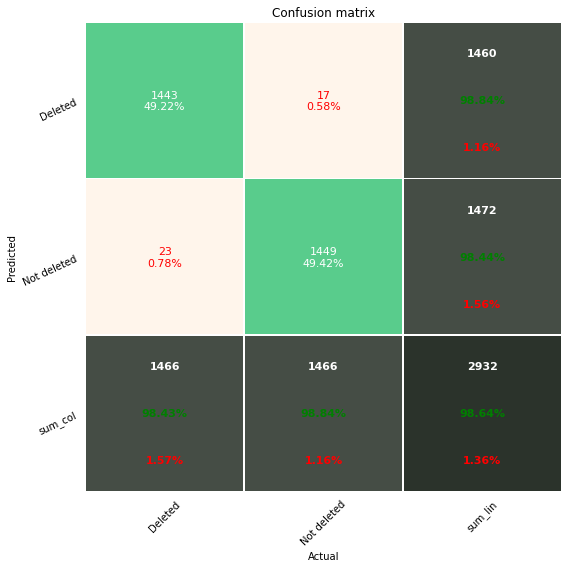


Testing metrics (HG004):
Accuracy: 75.77%
Precision: 77.26%
Recall: 73.03%
F1: 75.08%


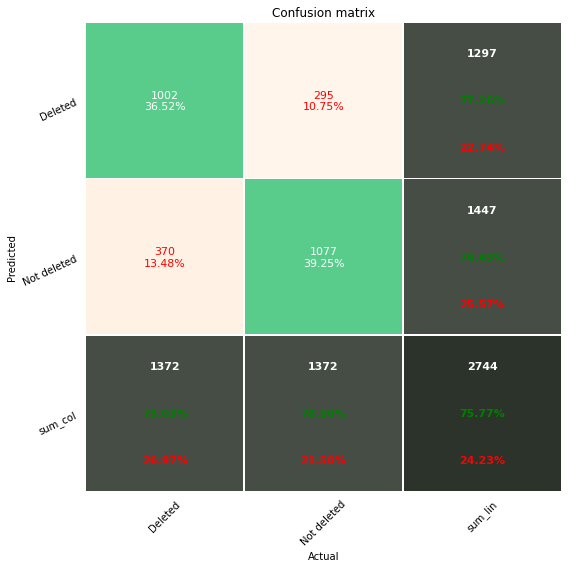



Signal feature importance:

Signal importance, summing their features' importance
	1. Coverage (0.10334908514373556)
	2. Clipped (0.1021121523084211)
	3. InsertSizeTooBig (0.09960380572475071)
	4. InterChr (0.09264657076138787)
	5. ForwardInsertSizeTooBig (0.08969560634774917)
	6. MAPQ0 (0.08920853852816094)
	7. MateUnmapped (0.08881447594947642)
	8. CigarIndels (0.08738039932908243)
	9. DiscordantTandemOrientation (0.08589077051779932)
	10. MappingErrors (0.08351108262147933)
	11. InsertSizeTooSmall (0.07778751276795728)

Signal importance, taking median of their features' importance
	1. Clipped (0.0010170165273888064)
	2. Coverage (0.00100830699054281)
	3. InsertSizeTooBig (0.0009667835367542849)
	4. InterChr (0.000925687845046192)
	5. MAPQ0 (0.0008844021985833575)
	6. ForwardInsertSizeTooBig (0.0008742308517499408)
	7. MateUnmapped (0.0008695769919722542)
	8. CigarIndels (0.0008538903032374828)
	9. DiscordantTandemOrientation (0.0008347083003712758)
	10. MappingErrors (0.000809328

In [24]:
(best_criterion,
 best_max_features,
 best_min_impurity_decrease,
 best_min_samples_split,
 best_n_estimators) = search_best_hyperparameters(X_HG003, y_HG003)

clf = RandomForestClassifier(criterion=best_criterion,\
                             max_features=best_max_features,\
                             min_impurity_decrease=best_min_impurity_decrease,\
                             min_samples_split=best_min_samples_split,\
                             n_estimators=best_n_estimators,\
                             n_jobs=n_jobs,\
                             random_state=random_state)

clf.fit(X_HG003, y_HG003)

print(f"\n\n{color.BOLD}Trained model on HG003{color.END}\n")
print("Training metrics (HG003):")
pred_HG003 = clf.predict(X_HG003)
show_metrics(y_HG003, pred_HG003)

print("\nTesting metrics (HG004):")
pred_HG004 = clf.predict(X_HG004)
show_metrics(y_HG004, pred_HG004)

print(f"\n\n{color.BOLD}Signal feature importance{color.END}:")
show_feature_importance(clf)

#### Train HG004, test HG003

Searching for best hyperparameters
Progress: 100%
Searching for best hyperparameters around previously found hyperparameters
Progress: 100%


Best criterion: gini
Best max_features: sqrt
Best min_impurity_decrease: 0.0
Best min_samples_split: 3
Best n_estimators: 1040


Trained model on HG004

Training metrics (HG004):
Accuracy: 99.13%
Precision: 98.98%
Recall: 99.27%
F1: 99.13%


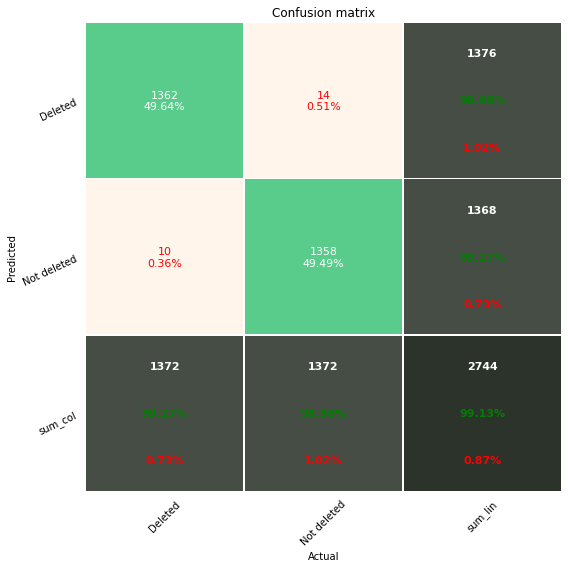


Testing metrics (HG003):
Accuracy: 74.32%
Precision: 76.08%
Recall: 70.94%
F1: 73.42%


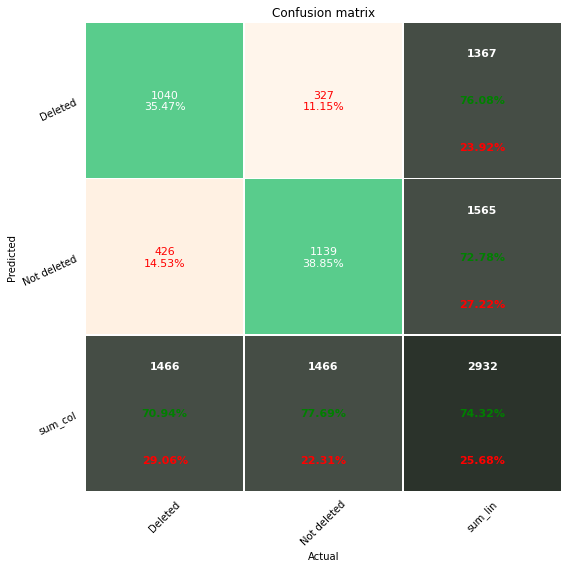



Signal feature importance:

Signal importance, summing their features' importance
	1. InterChr (0.12562648246647645)
	2. MateUnmapped (0.10517527013322807)
	3. MappingErrors (0.09994776922846592)
	4. Coverage (0.09992594277606293)
	5. DiscordantTandemOrientation (0.09636603018679725)
	6. MAPQ0 (0.09095179331364334)
	7. InsertSizeTooSmall (0.08100820716250874)
	8. InsertSizeTooBig (0.07994148159413939)
	9. CigarIndels (0.07620238221678036)
	10. Clipped (0.07561766459063238)
	11. ForwardInsertSizeTooBig (0.06923697633126519)

Signal importance, taking median of their features' importance
	1. InterChr (0.0012115864492858457)
	2. MappingErrors (0.0009727821240954826)
	3. MateUnmapped (0.0009542886327737751)
	4. Coverage (0.000937616162173901)
	5. MAPQ0 (0.0009001014048400232)
	6. DiscordantTandemOrientation (0.000865931279427455)
	7. InsertSizeTooSmall (0.000756263917139631)
	8. InsertSizeTooBig (0.0007491398066552188)
	9. CigarIndels (0.0007302728661734377)
	10. Clipped (0.0006920901478

In [27]:
(best_criterion,
 best_max_features,
 best_min_impurity_decrease,
 best_min_samples_split,
 best_n_estimators) = search_best_hyperparameters(X_HG004, y_HG004)

clf = RandomForestClassifier(criterion=best_criterion,\
                             max_features=best_max_features,\
                             min_impurity_decrease=best_min_impurity_decrease,\
                             min_samples_split=best_min_samples_split,\
                             n_estimators=best_n_estimators,\
                             n_jobs=n_jobs,\
                             random_state=random_state)

clf.fit(X_HG004, y_HG004)

print(f"\n\n{color.BOLD}Trained model on HG004{color.END}\n")
print("Training metrics (HG004):")
pred_HG004 = clf.predict(X_HG004)
show_metrics(y_HG004, pred_HG004)

print("\nTesting metrics (HG003):")
pred_HG003 = clf.predict(X_HG003)
show_metrics(y_HG003, pred_HG003)

print(f"\n\n{color.BOLD}Signal feature importance{color.END}:")
show_feature_importance(clf)

#### Conclusion

As we can see from these results, the training is exceptionally good in both cases. So the model has enough capacity, but it doesn't generalize very well as the testing metrics are below the training metrics, hinting that it probably overfits. However, the results are still drastically better than random for a sequence it wasn't trained on. The generalization issue may be due to a lack of data, or too much capacity, it would need deeper analysis to understand how we could enhance it.

Deep nets are known for having suprisingly good generalization when having huge training but training a deep net would require more computing power and more samples. Given the amount of data used here, a random forest seemed better and provides a way of understanding the signals' importance.

The hyperparameters are quite different between the two models, however the results are similar and after checking it looks like they don't influence too much the outcome (see [appendix](#Appendix)). But an interesting thing to notice is that the signals' importance is quite different between the two models and fairly consistent even when changing the hyperparameters (see [appendix](#Appendix)). Maybe this is due to overfitting or there actually are different ways of using the signals in order to improve the classification, depending on the analyzed sequence. So, the sequence intrinsic structure may influence each signal's importance and some filters may be more appropriated for some sequences than others. However, this would need further investigation to confirm.

## Appendix

### Appendix: Training HG003, testing HG004 with HG004 hyperparameters

Trained model on HG003 with HG004 hyperparameters

Training metrics (HG003):
Accuracy: 98.53%
Precision: 98.57%
Recall: 98.50%
F1: 98.53%


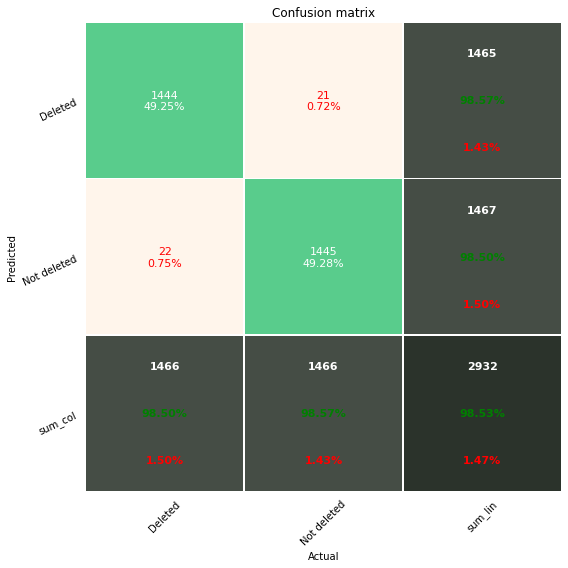


Testing metrics (HG004):
Accuracy: 75.51%
Precision: 77.69%
Recall: 71.57%
F1: 74.51%


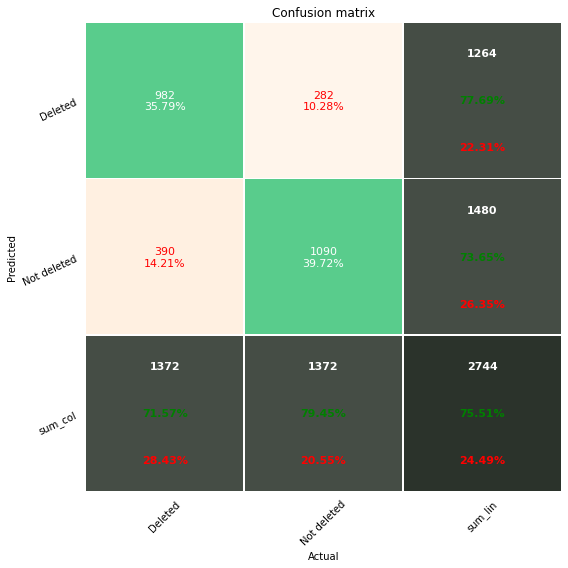



Signal feature importance:

Signal importance, summing their features' importance
	1. Clipped (0.10940757454193818)
	2. Coverage (0.10631899307968742)
	3. InsertSizeTooBig (0.10229571087263399)
	4. MateUnmapped (0.09149655189087115)
	5. InterChr (0.09002867680481504)
	6. ForwardInsertSizeTooBig (0.08892263032308595)
	7. CigarIndels (0.08851896325098078)
	8. MAPQ0 (0.08546397815511539)
	9. DiscordantTandemOrientation (0.08324292401037305)
	10. MappingErrors (0.08244940045104356)
	11. InsertSizeTooSmall (0.07185459661945554)

Signal importance, taking median of their features' importance
	1. Clipped (0.0010659574734770754)
	2. Coverage (0.0009785125894925593)
	3. InsertSizeTooBig (0.0009659666282613054)
	4. InterChr (0.0008925221215480324)
	5. MAPQ0 (0.0008559516050128113)
	6. CigarIndels (0.0008546687799916166)
	7. ForwardInsertSizeTooBig (0.0008462766406426126)
	8. MateUnmapped (0.0008443324436918856)
	9. DiscordantTandemOrientation (0.0008029662660452284)
	10. MappingErrors (0.00077

In [37]:
best_criterion = 'gini'
best_max_features = 'sqrt'
best_min_impurity_decrease = 0.0
best_min_samples_split = 3
best_n_estimators = 1040

clf = RandomForestClassifier(criterion=best_criterion,\
                             max_features=best_max_features,\
                             min_impurity_decrease=best_min_impurity_decrease,\
                             min_samples_split=best_min_samples_split,\
                             n_estimators=best_n_estimators,\
                             n_jobs=n_jobs,\
                             random_state=random_state)

clf.fit(X_HG003, y_HG003)

print(f"{color.BOLD}Trained model on HG003 with HG004 hyperparameters{color.END}\n")
print("Training metrics (HG003):")
pred_HG003 = clf.predict(X_HG003)
show_metrics(y_HG003, pred_HG003)

print("\nTesting metrics (HG004):")
pred_HG004 = clf.predict(X_HG004)
show_metrics(y_HG004, pred_HG004)

print(f"\n\n{color.BOLD}Signal feature importance{color.END}:")
show_feature_importance(clf)

### Appendix: Training HG004, testing HG003 with HG003 hyperparameters

Trained model on HG004 with HG003 hyperparameters

Training metrics (HG004):
Accuracy: 99.31%
Precision: 99.34%
Recall: 99.27%
F1: 99.31%


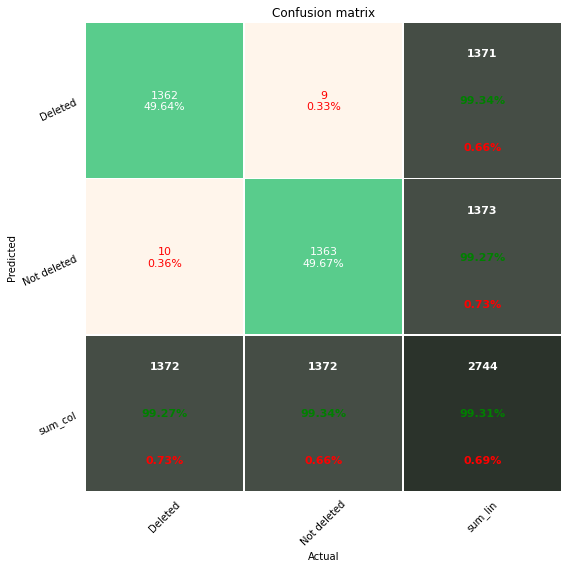


Testing metrics (HG003):
Accuracy: 74.66%
Precision: 76.37%
Recall: 71.42%
F1: 73.81%


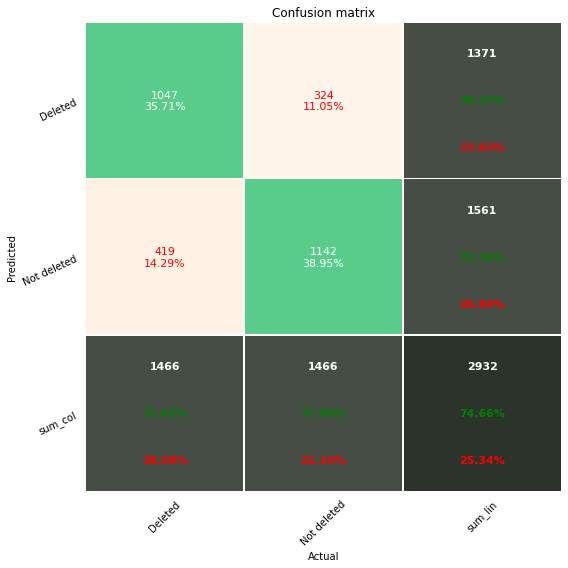



Signal feature importance:

Signal importance, summing their features' importance
	1. InterChr (0.11291568180499506)
	2. MAPQ0 (0.09876735111725762)
	3. MappingErrors (0.09753608025789377)
	4. Coverage (0.09714881114152485)
	5. MateUnmapped (0.09551229429735561)
	6. DiscordantTandemOrientation (0.09514200976384103)
	7. CigarIndels (0.08345758845344763)
	8. InsertSizeTooBig (0.08203472229429076)
	9. InsertSizeTooSmall (0.08059568315611507)
	10. Clipped (0.0804219369888643)
	11. ForwardInsertSizeTooBig (0.07646784072441443)

Signal importance, taking median of their features' importance
	1. InterChr (0.001100291502287991)
	2. MAPQ0 (0.0009694786084760839)
	3. MappingErrors (0.0009579631157543295)
	4. MateUnmapped (0.0009391468952703238)
	5. Coverage (0.0009264148888971544)
	6. DiscordantTandemOrientation (0.000923266647411294)
	7. CigarIndels (0.0008106642207263853)
	8. InsertSizeTooBig (0.0008063028504773802)
	9. InsertSizeTooSmall (0.0007901615450524516)
	10. Clipped (0.0007793650145

In [38]:
best_criterion = 'entropy'
best_max_features = 'log2'
best_min_impurity_decrease = 0.0
best_min_samples_split = 2
best_n_estimators = 1080

clf = RandomForestClassifier(criterion=best_criterion,\
                             max_features=best_max_features,\
                             min_impurity_decrease=best_min_impurity_decrease,\
                             min_samples_split=best_min_samples_split,\
                             n_estimators=best_n_estimators,\
                             n_jobs=n_jobs,\
                             random_state=random_state)

clf.fit(X_HG004, y_HG004)

print(f"{color.BOLD}Trained model on HG004 with HG003 hyperparameters{color.END}\n")
print("Training metrics (HG004):")
pred_HG004 = clf.predict(X_HG004)
show_metrics(y_HG004, pred_HG004)

print("\nTesting metrics (HG003):")
pred_HG003 = clf.predict(X_HG003)
show_metrics(y_HG003, pred_HG003)

print(f"\n\n{color.BOLD}Signal feature importance{color.END}:")
show_feature_importance(clf)

### Appendix: Training HG003 testing HG001 with HG003 hyperparameters

In [24]:
X_HG001, y_HG001 = generate_train_test_data('NA12878.sorted.chr2.vcf', 'HG001_2')

Signal Coverage 0.0% complete
Signal CigarIndels 0.0% complete
Signal Clipped 0.0% complete
Signal InsertSizeTooBig 0.0% complete
Signal ForwardInsertSizeTooBig 0.0% complete
Signal InterChr 0.0% complete
Signal DiscordantTandemOrientation 0.0% complete
Signal MappingErrors 0.0% complete
Signal InsertSizeTooSmall 0.0% complete
Signal MAPQ0 0.0% complete
Signal MateUnmapped 0.0% complete
Signal MappingErrors 6.1% complete
Signal Coverage 2.6% complete
Signal CigarIndels 33.8% complete
Signal Clipped 38.7% complete
Signal InsertSizeTooSmall 100.0% complete
Signal MappingErrors 11.3% complete
Signal MateUnmapped 100.0% complete
Signal MAPQ0 45.7% complete
Signal InsertSizeTooBig 100.0% complete
Signal Coverage 4.4% complete
Signal InterChr 100.0% complete
Signal MappingErrors 13.9% complete
Signal CigarIndels 69.2% complete
Signal ForwardInsertSizeTooBig 100.0% complete
Signal Clipped 82.2% complete
Signal Coverage 5.5% complete
Signal MappingErrors 18.6% complete
Signal Clipped 100.0% co

Trained model on HG003 with HG003 hyperparameters

Training metrics (HG003):
Accuracy: 98.64%
Precision: 98.84%
Recall: 98.43%
F1: 98.63%


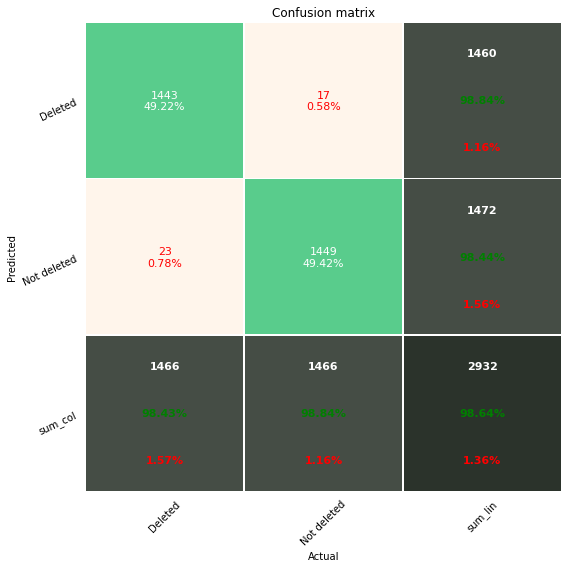


Testing metrics (HG001):
Accuracy: 60.25%
Precision: 58.99%
Recall: 67.21%
F1: 62.84%


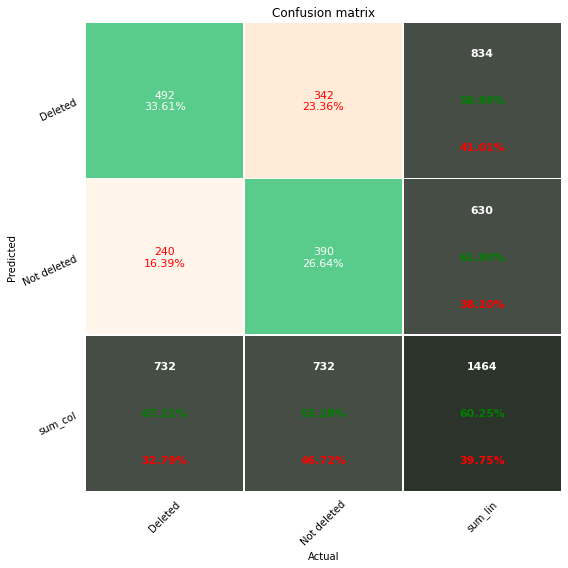



Signal feature importance:

Signal importance, summing their features' importance
	1. Coverage (0.10334908514373556)
	2. Clipped (0.1021121523084211)
	3. InsertSizeTooBig (0.09960380572475071)
	4. InterChr (0.09264657076138787)
	5. ForwardInsertSizeTooBig (0.08969560634774917)
	6. MAPQ0 (0.08920853852816094)
	7. MateUnmapped (0.08881447594947642)
	8. CigarIndels (0.08738039932908243)
	9. DiscordantTandemOrientation (0.08589077051779932)
	10. MappingErrors (0.08351108262147933)
	11. InsertSizeTooSmall (0.07778751276795728)

Signal importance, taking median of their features' importance
	1. Clipped (0.0010170165273888064)
	2. Coverage (0.00100830699054281)
	3. InsertSizeTooBig (0.0009667835367542849)
	4. InterChr (0.000925687845046192)
	5. MAPQ0 (0.0008844021985833575)
	6. ForwardInsertSizeTooBig (0.0008742308517499408)
	7. MateUnmapped (0.0008695769919722542)
	8. CigarIndels (0.0008538903032374828)
	9. DiscordantTandemOrientation (0.0008347083003712758)
	10. MappingErrors (0.000809328

In [25]:
best_criterion = 'entropy'
best_max_features = 'log2'
best_min_impurity_decrease = 0.0
best_min_samples_split = 2
best_n_estimators = 1080

clf = RandomForestClassifier(criterion=best_criterion,\
                             max_features=best_max_features,\
                             min_impurity_decrease=best_min_impurity_decrease,\
                             min_samples_split=best_min_samples_split,\
                             n_estimators=best_n_estimators,\
                             n_jobs=n_jobs,\
                             random_state=random_state)

clf.fit(X_HG003, y_HG003)

print(f"{color.BOLD}Trained model on HG003 with HG003 hyperparameters{color.END}\n")
print("Training metrics (HG003):")
pred_HG003 = clf.predict(X_HG003)
show_metrics(y_HG003, pred_HG003)

print("\nTesting metrics (HG001):")
pred_HG001 = clf.predict(X_HG001)
show_metrics(y_HG001, pred_HG001)

print(f"\n\n{color.BOLD}Signal feature importance{color.END}:")
show_feature_importance(clf)

The recall is higher than precision on HG001, this probalby comes from the fact that the curated vcf for HG003 is much more accurate than HG001's vcf. The vcf for HG001 tends to have more recognizable deletions and miss some deletions as it is generated with different filters. So some of the predicted deletions that are wrong based on this vcf might be correct if we were using another vcf.